<a href="https://colab.research.google.com/github/Israruddin293/Brest_Cancer/blob/main/btcpriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


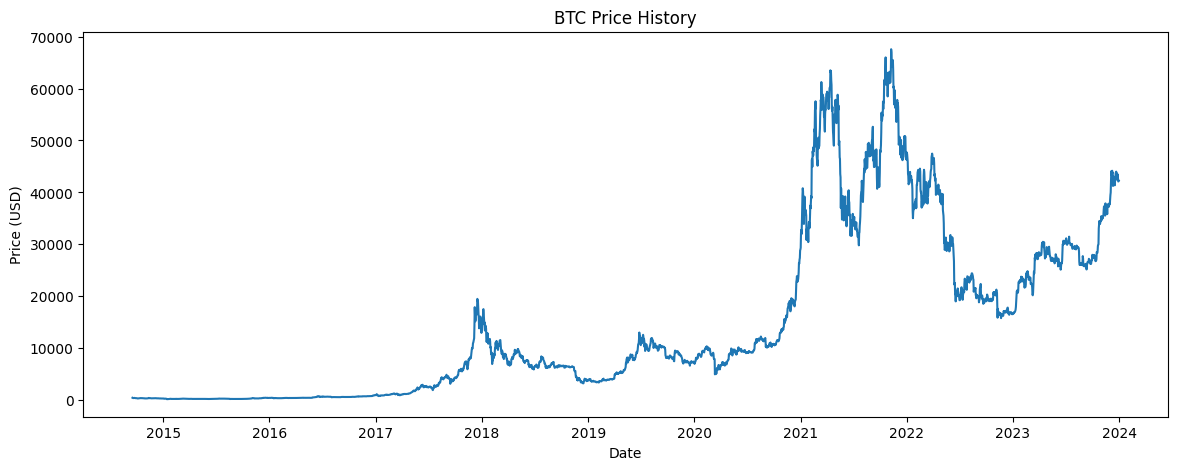

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
21/21 [==============================] - 1s 14ms/step


<ipython-input-7-bbe36e78755f>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


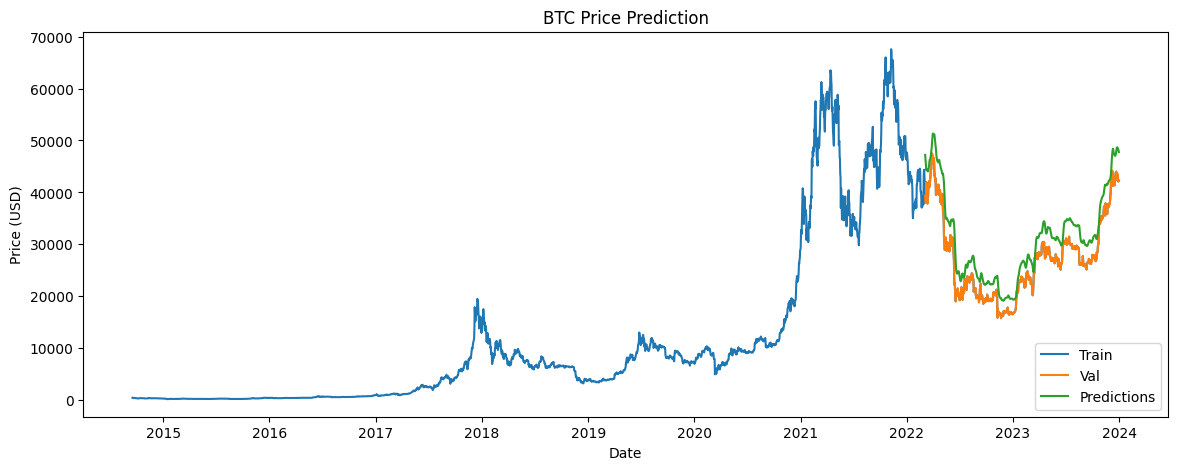

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Download historical BTC data
btc_data = yf.download('BTC-USD', start='2010-01-01', end='2024-01-01')
btc_data.to_csv('btc_price.csv')

# Load the data
data = pd.read_csv('btc_price.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(data['Close'])
plt.title('BTC Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Use closing price for prediction
data = data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 60  # Using the past 60 days to predict the next day
x, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input to be 3D [samples, time steps, features] which is required for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Get the predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual prices

# Ensure the valid dataset has the same length as predictions
valid = data[split + seq_length:]  # Shift to align with prediction steps
valid['Predictions'] = predictions

# Plot the predictions
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Actual Prices')
plt.plot(valid['Close'], label='Validation Prices')
plt.plot(valid['Predictions'], label='Predicted Prices')
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
